# Titanic Competition - who survives?

This is my attempt at predicting survival for the Kaggle titanic competition. I took a very structured approach to go through each step of the project in detail.

We are working with the version of the titanic dataset available on Kaggle which should be very easy to find. You need to have the dataset in your working directory to get this notebook to run. Other than that, all that is required is a basic installation of a python environment with data science libraries, for example using anaconda.

The overall objective is to build a model that predicts whether a person survives the titanic disaster, based on features such as age, sex, ticket fare, etc. As such, this is supervised learning problem, specifically binary classification.

What are we doing in this notebook:
- **Exploratory Data Analysis and Visualisation**: First, we need to understand what we are working with. EDA gives us an initial look at the data and its characteristics before diving into modelling.
- **Data Processing**: The raw dataset is not quite ready to be used in a machine learning model, so we'll need to do some data processing, mainly dealing with missing values and encoding categorical features.
- **Feature Engineering**: The titanic dataset has been studied extensively by the Kaggle community, and there have been many good suggestions for new features to build. These new features improve the performance of our models.
- **Model Selection and Cross Validation**: This is the fun part, where we will build various different models, tune their hyperparameters and assess their performance using cross validation.
- **Making Predictions**: The final (optional) part, where we make predictions for the test set, which could be submitted on the competition website.

Let's get started!

# Exploratory Data Analysis and Visualisation

In [1]:
# load relevant libraries
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
# inline magic
%matplotlib inline
import seaborn as sns; sns.set()

titanic_train_path = 'titanic/train.csv'
titanic_test_path = 'titanic/test.csv'

# load the training data
data_train = pd.read_csv(titanic_train_path)
# load test data
data_test = pd.read_csv(titanic_test_path)

For reference, here is the description of the column names/features:

- `PassengerId` is self-explanatory
- `Survived` is the target variable we are trying to predict
    - **0** means dead, **1** means survived
- `PClass`: passenger class (three ordered values 1, 2, and 3) can be used as proxy for socioeconomic status
- `SibSp`: Number of siblings - or - spouse
- `Parch`: Number of parents - or - children
- `Ticket`: Ticket number
- `Fare`: how much they paid
- `Cabin`: which cabin, is missing a lot
- `Embarked`: where the passengers boarded the ship **C** = Cherbourg, **Q** = Queenstown, **S** = Southampton

In [2]:
# first look at the data
display(data_train.head(n=10))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [3]:
display(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

In [4]:
display(data_train.describe())

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# List of cat. features
cat_features = ["Sex", "Cabin", "Embarked", "Ticket", "Name"]
# list of num features
num_features = ["Age", "SibSp", "Parch", "Fare", "Survived", "Pclass"]

for f in cat_features:
    print(f, " Unique values", len(data_train[f].unique()))

Sex  Unique values 2
Cabin  Unique values 148
Embarked  Unique values 4
Ticket  Unique values 681
Name  Unique values 891


We can already make a couple of observations from this:
- Only about 38% of passengers survived
- Age and Cabin are missing a substantial number of values, which we need to deal with in the data processing step
- the test set may values missing in other columns, which we should anticipate
- Cabin, Ticket, and Name have a large number of unique values, which we need to group and process, or get rid of

Let's explore some of this data visually.

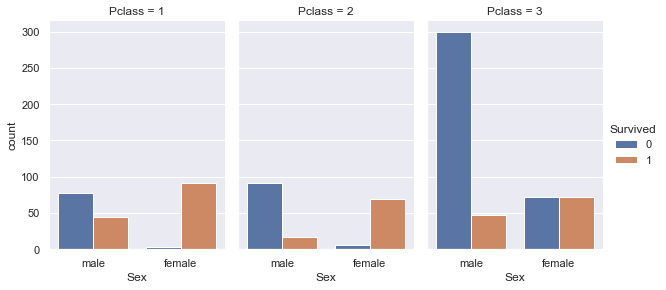

In [6]:
# plot survival breakdown by sex and pclass
sns.catplot(data=data_train, x='Sex', hue='Survived', col='Pclass', kind='count', height=4, aspect=0.7);

This categorical plot clearly shows that there is a survival advantage to being female or upper-class. Women in the first and second class have very high survival rates, and even for third class women, the survival rate is almost 50%. Men are not as lucky, second and third class men have it especially bad.

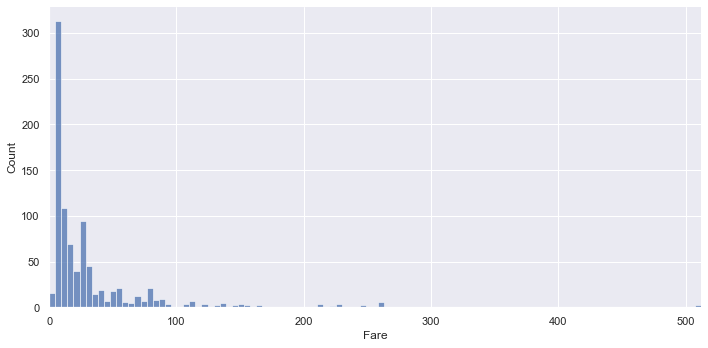

In [7]:
# plot fare distribution
sns.displot(data=data_train, x='Fare', kind='hist', aspect=2)
plt.xlim([0,data_train['Fare'].max()]);

The distribution of the ticket fare is very skewed, with a long tail towards high ticket fares. Most passengers paid below 50 units of currency for their ticket.

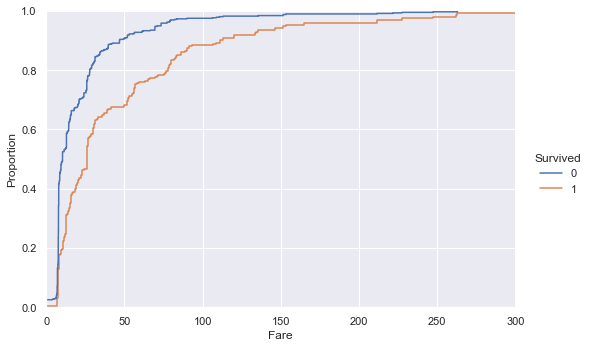

In [8]:
# plot fare breakdown by survival in ecdf plot
sns.displot(data=data_train, x='Fare', hue='Survived', kind='ecdf', aspect=1.5)
plt.xlim([0,300]);

The empirical cumulative distribution function allows us to check if passenger who survived paid more for their tickets. It seems that this is the case: the ECDFs for dead and survivors are quite different, with the ECDF for the survivors being offset towards higher ticket fare.

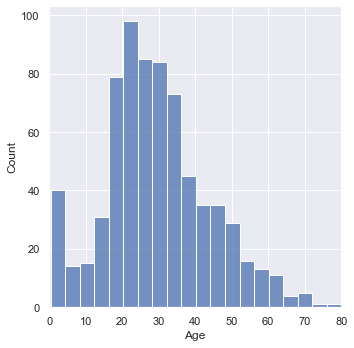

In [9]:
# plot age distribution
sns.displot(data=data_train, x='Age', kind='hist')
plt.xlim([0.0,80.0]);

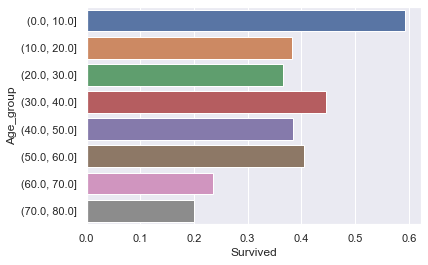

In [10]:
# Survival breakdown by age group
data_train['Age_group'] = pd.cut(data_train['Age'], [0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0])
grouped_age = data_train.groupby('Age_group')
age_survival = grouped_age[['Survived']].agg('mean')
sns.barplot(data=age_survival, y=age_survival.index, x='Survived');

Difference in survival rates as a function of age are not as clear. Children seem more likely to survive, and older people less likely.

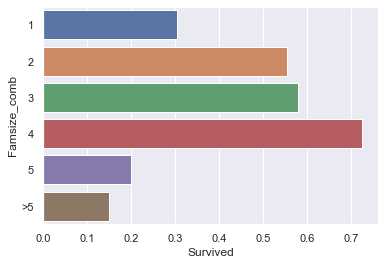

In [11]:
# Survival breakdown by Family size
data_train['Famsize'] = 1 + data_train['SibSp'] + data_train['Parch']
data_train['Famsize_comb'] = pd.cut(data_train['Famsize'], [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, np.inf])

grouped_fam = data_train.groupby('Famsize_comb')
fam_survival = grouped_fam[['Survived']].agg('mean')
sns.barplot(data=fam_survival, y=fam_survival.index, x='Survived')
plt.yticks(ticks=[0,1,2,3,4,5], labels=['1', '2', '3', '4', '5', '>5']);

Travelling with family (Family size between 2 and 4) also seems to be a survival advantage.

Some conclusions we can draw from this EDA:
- Being female and upper-class is a survival advantage
- Passenger who survived had paid higher fares
- Children were more likely to survive
- Travelling in a family of reasonable size is a survival advantage

Based on these observations, it would be useful to construct derived features to include in the model.

## Data Processing and Feature Engineering

We want to build processing pipelines that can be used for both the training and test data. We also want to build a few new, reasonable features that might be useful based on our EDA. It makes sense to this in the same step and to put everything in a pipeline.

In [12]:
# reload the data (remove the changes we made above)
data_train = pd.read_csv(titanic_train_path)

In [13]:
# import preprocessing tools
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# process name data: only keep the titles
titles = data_train["Name"].apply(lambda x: x.split(',')[1].split('.')[0].strip())
print("Unique titles:", titles.unique())
title_categories = {
    'Mr':'Mr',
    'Mrs':'Mrs',
    'Miss':'Miss',
    'Master':'Master',
    'Don':'Royalty',
    'Rev':'Official',
    'Dr':'Official',
    'Mme':'Mrs',
    'Ms':'Miss',
    'Major':'Official',
    'Lady':'Royalty',
    'Sir':'Royalty',
    'Mlle':'Miss',
    'Col':'Official',
    'Capt':'Official',
    'the Countess':'Royalty',
    'Jonkheer':'Royalty'
}

# create family size and adult/child features
def preprocess_df(df,title_categories):
    df["Cabin"] = df["Cabin"].fillna("U").apply(lambda x: x[0])
    df["Fare"] = np.sqrt(df["Fare"])
    df["Name"] = df["Name"].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    df["Title"] = df["Name"].apply(lambda x: title_categories[x] if x in title_categories.keys() else "Unknown")
    df["FamSizeNum"] = df["SibSp"] + df["Parch"]
    df["FamSize"] = df["FamSizeNum"].apply(lambda x: "single" if x == 0 else ("small" if x <= 4 else "large"))
    df["TicketType"] = df["Ticket"].apply(lambda x: 1 if not x.isnumeric() else 0)
    df["Adult_or_Child"] = df["Age"].apply(lambda x: "unknown" if math.isnan(x) else ("child" if x < 18 else "adult"))
    df = df.drop(["Ticket","Name","PassengerId","FamSizeNum"],axis="columns")
    return df

df_train = preprocess_df(data_train.copy(),title_categories)
df_test = preprocess_df(data_test.copy(),title_categories)

X_train, y_train = df_train.loc[:,"Pclass":], df_train["Survived"]
X_test = df_test

# update features to reflect the fact that we dropped some columns
cat_features = ["Sex", "Cabin", "Embarked",'Title', 'FamSize', 'TicketType', 'Adult_or_Child']
num_features = ["Age", "SibSp", "Parch", "Fare", "Pclass"]

# define preprocessing pipeline steps here
cat_imputer = SimpleImputer(strategy="most_frequent")
OH_enc = OneHotEncoder(handle_unknown="ignore",sparse=False)
num_imputer = SimpleImputer(strategy="median",add_indicator=True)
robustscale = RobustScaler()

cat_transformer = Pipeline(steps=[("impute",cat_imputer),("onehot", OH_enc)])
num_transformer = Pipeline(steps=[("impute",num_imputer),("scale", robustscale)])

# define preprocessor, will turn the DataFrame into an array of numbers (remove column names)
preprocessor = ColumnTransformer(transformers=[('num',num_transformer,num_features),
                                              ('cat',cat_transformer,cat_features)])

Unique titles: ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']


The preprocessing steps defined above can be used in a full pipeline that we'll build now.

## Model Selection and Cross-Validation

In [14]:
# import ML classifier models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
# Validation and parameter tuning
from sklearn.model_selection import cross_val_score, GridSearchCV

# try baseline random forest model
rf_model = RandomForestClassifier()
pipe_model = Pipeline(steps=[('preproc', preprocessor), ('model', rf_model)])
cv_scores = cross_val_score(pipe_model, X_train, y_train, cv=5)
print('Score for baseline random forest model:', sum(cv_scores)/len(cv_scores))

Score for baseline random forest model: 0.7968614650681063


In [ ]:
# optimise RF model with grid search cv

param_grid = {'model__max_depth' : [8, 10, 12],
                 'model__n_estimators': [50, 10],
                 'model__max_features': ['sqrt'],
                 'model__min_samples_split': [2, 3, 10],
                 'model__min_samples_leaf': [1, 3, 10],
                 'model__bootstrap': [True, False],
                 }

rf_model = RandomForestClassifier()
pipe_model = Pipeline(steps=[('preproc', preprocessor), ('model', rf_model)])
grid_search = GridSearchCV(pipe_model, scoring='accuracy', param_grid=param_grid, refit=True)

grid_search = grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
parameters = grid_search.best_params_
print('Best (cv-opt) score for random forest: {}'.format(grid_search.best_score_))

In [ ]:
# let's run over a few more models

def select_model(name, model, preprocessor, param_grid):
    """ Run baseline and grid search CV optimised models and get scores.
        Return best estimator. """
    # baseline model
    pipe_model = Pipeline(steps=[("preproc",preprocessor),("model",model)])
    scores = cross_val_score(pipe_model,X_train,y_train,cv=5)
    print("Baseline {} score:".format(name), sum(scores)/len(scores))
    # optimised model
    pipe_model = Pipeline(steps=[("preproc",preprocessor),("model",model)])
    grid_search = GridSearchCV(pipe_model,
                               scoring='accuracy',
                               param_grid=param_grid,
                               cv=5,refit=True)
    grid_search = grid_search.fit(X_train, y_train)
    print('Best (cv-opt) score: {}'.format(grid_search.best_score_))
    print('Best parameters:', grid_search.best_params_)
    return grid_search.best_estimator_

svc_param_grid = param_grid = {
                 'model__C' : [0.3,0.5,1.0,1.5,2.0],
                 'model__kernel': ['linear','poly','rbf','sigmoid'],
                 'model__degree': [2,3,4],
                 'model__gamma': ['scale','auto'],
                 }

# find best SVC
best_svc = select_model('SVC', SVC(), preprocessor, svc_param_grid)

In [ ]:
# find the best log reg
logreg_param_grid = {
                 'model__penalty' : ['l2'],
                 'model__C': [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
                 }

best_logreg = select_model('Log Reg', LogisticRegression(), preprocessor, logreg_param_grid)

In [ ]:
# best knn model
knn_param_grid = {'model__n_neighbors' : [3,4,5,6,7,8],
                 'model__weights': ['uniform','distance']
                 }

best_knn = select_model('KNN', KNeighborsClassifier(), preprocessor, knn_param_grid)

## Detailed Model Assessment: Logistic Regression

GridSearchCV is great for finding optimal model hyperparameters, but it's not the most convenient when we're trying to analyse a series of performance metrics for the same model. It that case, StratifiedKFold is easier to work with.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, plot_roc_curve

# initialise stratified k fold
cv = StratifiedKFold(n_splits=5)
# use regularization parameter from above
classifier = Pipeline(steps=[('preproc', preprocessor), ('logreg', LogisticRegression(C=1.5))])

# metrics to keep track of across folds
true_pos_rates = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
acc = []
prec = []
recall = []

# plot ROC curves and save metrics for each fold
fig, ax = plt.subplots(figsize=[10.0,8.0])
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    classifier.fit(X_train.loc[train], y_train.loc[train])
    viz = plot_roc_curve(classifier, X_train.loc[test], y_train.loc[test], name='ROC Fold {}'.format(i+1), 
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    true_pos_rates.append(interp_tpr)
    aucs.append(viz.roc_auc)
    # other metrics
    y_pred = classifier.predict(X_train.loc[test])
    acc.append(accuracy_score(y_train.loc[test], y_pred))
    prec.append(precision_score(y_train.loc[test], y_pred))
    recall.append(recall_score(y_train.loc[test], y_pred))
    
print('Average accuracy:',np.mean(acc))
print('Average precision:',np.mean(prec))
print('Average recall:',np.mean(recall))
    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr = np.mean(true_pos_rates, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

# standard deviation of the mean ROC curve
std_tpr = np.std(true_pos_rates, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic - Titanic Logistic Regression")
ax.legend(loc="lower right");

## Who is the luckiest survivor?

With models that predict probabilities, we can try to find the luckiest survivor: the person whose probablity of survival is lowest, but who still made it. Let's try this with our logistic regression. In principle, we should do this with leave-one-out cross validation, but here I'll stick with the already trained model.

In [ ]:
# order of classes in the model
best_logreg.classes_

In [ ]:
passenger_info = data_train.copy()
passenger_info['pred_surv_prob'] = best_logreg.predict_proba(X_train)[:,1]

In [ ]:
passenger_info[passenger_info['Survived'] == 1].sort_values('pred_surv_prob').head(n=10)

Based on this, Mr. Karl Edwart Dahl is the luckiest survivor. Looking at the first few rows of the dataframe, we see that there are a whole number of other men with low predicted survival probabilities that still made it. This makes sense based on the patterns that we observed in the very beginning: All of them are adult men, travelling in second or third class, with low fares and often without family.

# Competition predictions

Here we make final predictions for the test set using the previously trained models.

In [ ]:
predictions = data_test.copy()
predictions['Survived_pred'] = best_rf.predict(X_test)

In [ ]:
predictions[['PassengerId', 'Survived_pred']]